# COMP52615 - Computer vision resit

## 1.0 Introduction

This assignment aims to simulate the trajectory of the athlete on the badminton court from real world in a 2D top view. To implement this objective, this assignment could be decomposed into three subtask, including the identification of the court and the player, as well as the simulation of their motion in a 2D top view. Firstly, the edge and conner detection can be used to identify the lines and boundaries of the court in the task one. The CV2(OpenCV) libray is a useful libray for this task in terms of the image process. Although the color pattern of this libray, which is BGR, is likely to cause confusion in the process of converting color, a majority of the graph algorithms could be explored from this library, ranging from image loading to visual computing, such as canny(a method of edge detection) and position transform from 3d view to 2d view. For example, the image loading of this library is efficient and general. Unlike the image class from PIL, loading image as a customized class, the operation of this library is based on numpy.ndarray. This means the data of image could be supported by multiple computing. Secondly, YOLO(you only look once) is useful for the detection of the multiple targets, as well as the classification and the pose recognition. This is becuase this library offers the pretrained model for the person class, which can be marked by a existing box bounding. Finally, the Deep sort contributes to multiple target track because this library can chase the multiple objects by the id of the tracker. In addition to the techniques mentioned above, the use of the virtual environment is helpful to tackle the compatibility of the python packages as they tend to depend on the specific version of the library for different projects. For example, the ultralytics package for yolo relys on the version 1.26.4 of the numpy package. Thus, the dependencies of the libraries tend to keep cautious.

### Environment

The environment means the dependencies to keep the code work normally, including the main configuration of parameters and modules. For example, this jupyter notebook tested on Anaconda, a platform incluing plenty of installed library in advance.

#### The virtual environment

The switch of virtual environment relys on the switch of the kernel because it could not activate the virtual environment directly in the current jupyternotebook; Consequently, the use of terminal is necessary to bind the virtual environment and the kernel setting.

In [ ]:
conda create -n sport_target python=3.11 -y

In [ ]:
conda install jupyter ipykernel -c conda-forge

terminal: conda activate sport_target

In [ ]:
python -m ipykernel install --user --name=sport_target --display-name "python sport_target_env"

terminal: conda install jupyter ipykernel -c conda-forge <br>
terminal: python -m ipykernel install --user --name=sport_target --display-name "python sport_target_env" <br>

#### Test the current vironment

In [1]:
import sys
print(sys.executable)

/opt/anaconda3/envs/sport_target/bin/python


In [ ]:
conda info --envs

#### The installation of packages

In [ ]:
pip install ultralytics

In [ ]:
pip uninstall -y numpy

In [ ]:
pip install numpy==1.26.4 

In [ ]:
pip install deep-sort-realtime

#### The modules used in this task

The management of the modules may reduce the overhead of modules import and avoid the clash of the name. To be more specific, some keyword of the module must not be used as the name of the variables. This is becuase the efficiency of python is mainly based on the analysis of the name behind the scene, which is straightforward to cause confusion by the subtle and trivial details. As a result, such code is a very programming language of case sensitive.

In [3]:
# module import
import matplotlib.pyplot as plt
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort

import re
import glob
from shapely.geometry import Polygon, box



#### The configuration of the global parameters

The global parameters includes the path of imags, the dimention of the real badminton court, the setting of the color for the annotated legends. The order of the images is crucial to analyze the serial task because the motion of the players represented as the sequence frames in a chronological order.

##### Code

In [5]:
def sorted_by_number(name):
    '''
    sort the name by number 
    '''
    match_obj = re.search(r'\d+', name) # find the first whole number from a string
    return int(match_obj.group()) if match_obj else -1 # .group return the whole matched text

# load the image path in a ascending sequence
single_imgs = sorted(glob.glob("SINGLEframes/*.jpeg"), key = sorted_by_number)
double_imgs = sorted(glob.glob("DOUBLEframes/*.jpeg"), key = sorted_by_number)

# real size of badminton unit M
width_size = 13.41
height_size = [5.18, 6.10]

bg_color = (0, 255, 0)
line_color = (255, 255, 255)
box_color = (255, 0, 0)
common_player = 0.9

In [7]:
# check the order of the images
print(single_imgs[0])
print(single_imgs[10])
print(single_imgs[-1])
print(double_imgs[0])
print(double_imgs[10])
print(double_imgs[-1])

SINGLEframes/frame1-SINGLE.jpeg
SINGLEframes/frame11-SINGLE.jpeg
SINGLEframes/frame501-SINGLE.jpeg
DOUBLEframes/frame562-DOUBLE.jpeg
DOUBLEframes/frame572-DOUBLE.jpeg
DOUBLEframes/frame813-DOUBLE.jpeg


## 1.1 Task1: the identification of the Court

### Method

As the area of the court is quadrilateral and its color is distinct from the surrounding, color filter is used to recoginze its boundary. The `cv2.inRange` function is useful to filter the specific color of the image as a mask. The `cv2.findContours` function is helpful to look for the largest area of the polygons.<br>

Within this area, the edge detection is used to identify the white line. One of the methods is the `Canny` method, which can be called by `cv2.Canny`. This method includes Gaussian blur, gradient computing and the connection of the edges. The main formula is<br> 
gradient: $\sqrt{G_x^2 + G_y^2} \approx |G_x| + |G_y|$<br>
direction: $\theta(x,y) = tan^{-1}(G_x,G_y)$<br>

From the edges, the `cv2.HoughLinesP` function can be used to extract the straight line from the court. The `cv2.perspectiveTransform` function is useful to convert the coordinate of the image to 2D top view. The main formula is<br>

$\begin{bmatrix} x^\prime\\y^\prime\\z^\prime\end{bmatrix} = H \cdot \begin{bmatrix} x\\y\\1 \end{bmatrix}$<br>
H is the homographt matrix


### Code

In [9]:
# use color filter to identify the floor of court
def get_conner(img):

    sample_img = img.copy()

    sample_img_hsv = cv2.cvtColor(sample_img,cv2.COLOR_BGR2HSV)
    green_lower = np.array([35, 40, 40])
    green_upper = np.array([85, 255, 255])
    mask_court = cv2.inRange(sample_img_hsv, green_lower, green_upper)
    result_mask = cv2.bitwise_and(sample_img, sample_img, mask=mask_court)
    #gray_conner = cv2.cvtColor(result_mask,cv2.COLOR_BGR2GRAY)
    # reduce the noise
    kernel_smooth = np.ones((5, 5), np.uint8)
    mask_court = cv2.morphologyEx(mask_court, cv2.MORPH_OPEN, kernel_smooth)
    mask_court = cv2.morphologyEx(mask_court, cv2.MORPH_CLOSE, kernel_smooth)
    # find out the conner of the floor
    outline_floor, _ = cv2.findContours(mask_court, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conner_court = None
    max_area = 0
    rect_points = None
    for outline in outline_floor:
        outline_area = cv2.contourArea(outline)
        perimeter = cv2.arcLength(outline, True)
        
        if outline_area > max_area:
            max_area = outline_area
            increase_perimeter = 0.02
            conner_court = cv2.approxPolyDP(outline, increase_perimeter * perimeter, True) 
            conner_court = conner_court.reshape(-1, 2)
            if(len(conner_court)>4):
                conner_court_sorted = conner_court[conner_court[:,0].argsort()]
                conner_court_new =[conner_court_sorted[0],conner_court_sorted[1], conner_court_sorted[-2], conner_court_sorted[-1]]
                conner_court = np.array(conner_court_new)
            # top-left 
            rect_points = np.zeros((4, 2), dtype='uint')
            sum_points = conner_court.sum(axis=1)
            rect_points[0] = conner_court[np.argmin(sum_points)]
            rect_points[2] = conner_court[np.argmax(sum_points)]

            diff_points = np.diff(conner_court, axis=1)
            rect_points[1] = conner_court[np.argmin(diff_points)]
            rect_points[3] = conner_court[np.argmax(diff_points)]

    return rect_points

# calculate the scale of the map from 3d view to 2D view
def get_scale_map(conner, single):
    top_view_width = 600
    real_width = width_size
    if single:
        real_height = height_size[0]
    else: 
        real_height = height_size[1]
    top_view_height = int(real_height/real_width * top_view_width)
    
    top_view_rect = np.array([
        [top_view_width + 10, top_view_height + 10],         
        [top_view_width + 10, 10],
        [10, 10],
        [10, top_view_height + 10]
    ], dtype = np.float32)

    # calculate the scale of the perspective scale
    perspective_region = conner.reshape(4, 2).astype(np.float32)
    scale_map = cv2.getPerspectiveTransform(perspective_region, top_view_rect)
    return scale_map, top_view_width, top_view_height
    
def get_2d_point(src_point, scale_3d_2d):
    points_3d = src_point.reshape(-1, 1, 2)
    dst_points = cv2.perspectiveTransform(points_3d,scale_3d_2d).reshape(-1, 2)
    return dst_points

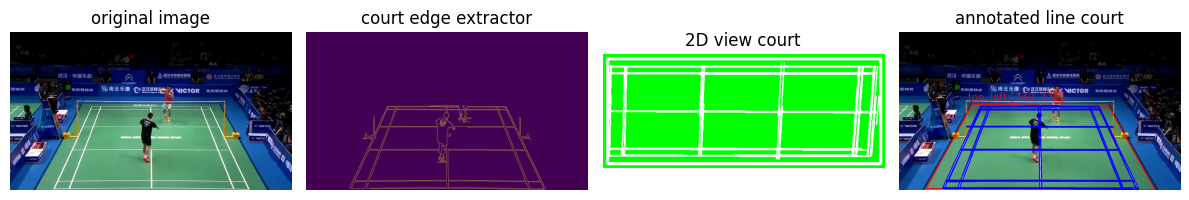

In [11]:

img_path = single_imgs[20]
# load the img as a array, the color pattern is BRG
sample_img = cv2.imread(img_path)
sample_img_rgb = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)

def draw_line(img, conner, single, show_grid):
       
    # line detection
    # shrink the region of the court 
    blank_mask = np.zeros(img.shape[:2], dtype = np.uint8)
    region = conner.astype(np.float32)#.reshape(-1, 2)
    center = cv2.moments(region)
    cx = int(center["m10"] / center["m00"])
    cy = int(center["m01"] / center["m00"])
    center_point = np.array([cx, cy], dtype = np.float32)
    scales = np.array([0.98,1],dtype = np.float32)
    shrunk_region = center_point + scales * (region - center_point)
    shrunk_region = shrunk_region.astype(np.int32).reshape(-1, 1, 2)

    cv2.fillPoly(blank_mask, [shrunk_region], 255)

    sample_img_line = img.copy()
    sample_img_floor_gray = cv2.cvtColor(sample_img_line, cv2.COLOR_BGR2GRAY)
    sample_img_floor_gray = cv2.convertScaleAbs(sample_img_floor_gray, alpha = 1.5, beta = 0)

    sample_blur = cv2.GaussianBlur(sample_img_floor_gray, (5,5), 0)

    # extract the line using edge detection
    court_edges = cv2.Canny(sample_blur, threshold1 = 50, threshold2 = 150)
    court_edges_extractor = cv2.bitwise_and(court_edges, court_edges, mask = blank_mask)

    sample_img_floor = img.copy()
    sample_img_floor = cv2.cvtColor(sample_img_floor, cv2.COLOR_BGR2RGB)


    cv2.drawContours(sample_img_floor, [conner], 0, (255, 0, 0), 3)
    top_left = conner[0]
    cv2.putText(sample_img_floor,f"top_left:{top_left}",top_left-20,cv2.FONT_HERSHEY_SIMPLEX, 1.5, box_color, 2, cv2.LINE_AA)
        
    # identify the white line of the ground
    court_lines = cv2.HoughLinesP(
        court_edges_extractor,
        rho=1,
        theta = np.pi / 180,
        threshold = 80,
        minLineLength = 50,
        maxLineGap = 200
    )

    # convert the 3D view to the 2D top view
    scale_map, top_view_width, top_view_height = get_scale_map(conner, single)
    top_view_width = 600
    real_width = width_size
    real_height = height_size[0] if single else height_size[1]
    top_view_height = int(real_height/real_width * top_view_width)
    top_view_channel = 3

    top_view_image = np.zeros((top_view_height+20, top_view_width+20, top_view_channel), dtype = np.uint8)
    top_view_image[:] = bg_color
    top_view_rect_frame = np.array([
        [top_view_width + 10, top_view_height + 10],
        [top_view_width + 10, 10],
        [10, 10],
        [10, top_view_height + 10]
    ], dtype = np.int32)
    top_view_rect_frame = top_view_rect_frame.reshape((-1, 1, 2))
    cv2.polylines(top_view_image, [top_view_rect_frame], isClosed = True, color = line_color, thickness = 5)
    
    # mark the white line of the ground
    if court_lines is not None:
        for line in court_lines:
            x1, y1, x2, y2 = line[0]
            if show_grid:
                cv2.line(sample_img_floor, (x1, y1), (x2, y2), (0, 0, 255), 4)
            multi_points = np.float32([[x1, y1],[x2, y2]])#np.float32([[x1, y1],[x2, y2]]).reshape(-1, 1, 2)
            dst_points = get_2d_point(multi_points, scale_map)#cv2.perspectiveTransform(mul_points,scale_map).reshape(-1, 2)
            x1_2d, y1_2d = dst_points[0].astype(np.int32)
            x2_2d, y2_2d = dst_points[1].astype(np.int32)
            cv2.line(top_view_image, (x1_2d, y1_2d), (x2_2d, y2_2d), line_color, 2)
                
    return sample_img_floor, court_edges_extractor, top_view_image, scale_map


def draw_outline(img, single, show_grid):
    fit_approx = get_conner(img)
    sample_img_floor, court_edges_extractor, top_view_image, scale_map = draw_line(img, fit_approx, single, show_grid)
    
    return sample_img_floor, court_edges_extractor, top_view_image, scale_map

sample_img_floor, court_edges_extractor, top_view_image, _ = draw_outline(sample_img, True, True)

# plot the result        
fig, axes = plt.subplots(1, 4, figsize = (12, 6))

axes[0].axis('off')
axes[0].imshow(sample_img_rgb)
axes[0].set_title("original image")

axes[1].axis('off')
axes[1].imshow(court_edges_extractor)
axes[1].set_title("court edge extractor")

axes[2].axis('off')
axes[2].imshow(top_view_image)
axes[2].set_title("2D view court")

axes[3].axis('off')
axes[3].imshow(sample_img_floor)
axes[3].set_title("annotated line court")

plt.tight_layout()
plt.show()

### Result

As the figure is shown above, a 2d top view court(image 3) is built, and the lines(blue) and the bourdary(red) of the court(image 4) are highlighted. It is clear that the `cv2.HoughLinesP` function is not good enough to extract and merge the edge in a perspective view. The `cv2.approxPolyDP` function is unstabele to get a regular shape with four corners. The map of the points from 3d-view to 2d-top view links to the order of the points in a clockwise or counter-clockwise direction, otherwise, some rotation issues may appear.

## 1.2 Task2: the recognition of the Player

### Method

This task mainly tested the function of the YOLO on the detection and classification of the person.<br>
The link of YOLO is: https://docs.ultralytics.com/models/yolo12/<br> This library is supported for pre-trained dataset and customized dataset.
The basic rule of this method is that the image is split into some patches. The computing model is based on the proportion of the overlap area between the patch and the object, which called "Iou"(intersection over union). The formula is:<br>
IoU = area of overlap / area of union<br>
The score of this model generated from the accurate rate of the classification of the target and its IoU, the formula is:<br>
score = P(class_i|object) * P(object) * IoU($\frac{truth}{predicted}$)<br>
P: probability

The detection of the player is based on the court region. The box of the person removed if the area of the box of the person outside the court is more than 90% of the total area. The `predict` function of this model could be used to identify the person on the image. The data of the box and the classification can be obtained from the result through the attribute `boxes.xyxy` and `.boxes.cls`.

### Code

In [13]:
sample_imgs = [single_imgs[10], double_imgs[668-562]]

In [15]:

# Load a COCO-pretrained YOLO12n model
model_y12 = YOLO("yolo12n.pt")
# Train the model on the COCO8 example dataset for 100 epochs
# results_y12 = model_y12.train(data="coco8.yaml", epochs=100, imgsz=640)

# Run inference with the YOLO12n model on the sample image
sample_img_y12 = cv2.imread(sample_imgs[1]).copy()
results_target_y12 = model_y12.predict(sample_img_y12, classes = [0])



0: 384x640 9 persons, 3583.1ms
Speed: 35.4ms preprocess, 3583.1ms inference, 17.3ms postprocess per image at shape (1, 3, 384, 640)


In [17]:
# Load a COCO-pretrained YOLOv8n model
model_y8 = YOLO("yolov8n.pt")
sample_img_y8 = cv2.imread(sample_imgs[1]).copy()
results_target_y8 = model_y8.predict(sample_img_y8, classes = [0])


0: 384x640 7 persons, 4471.9ms
Speed: 17.9ms preprocess, 4471.9ms inference, 9.5ms postprocess per image at shape (1, 3, 384, 640)


In [19]:
def is_player(x1, y1, x2, y2, conner_ploy):
    person_square = box(x1, y1, x2, y2)
    overlap_part = person_square.intersection(conner_ploy)
    area_overlap = overlap_part.area
    return area_overlap >= (1 - common_player) * (y2 - y1) * (x2 - x1)
    
def draw_player_position(top_view, positions, scale_3d_2d):
    points_2d = get_2d_point(positions, scale_3d_2d)
    for pos in points_2d:
        pos_center = tuple((pos.astype(int)))
        cv2.circle(top_view, pos_center, radius=5, color=box_color, thickness=-1)

def get_target_box(img):
    results_target_y12 = model_y12.predict(img, classes = [0])
    person_boxes_yolo12 = []
    for box_y12, cls_y12 in zip(results_target_y12[0].boxes.xyxy, results_target_y12[0].boxes.cls):
        if cls_y12 == 0: # person is class = 0
            person_boxes_yolo12.append(box_y12)
    return person_boxes_yolo12
    
def get_target_player(img):
    
    person_boxes_yolo12 = get_target_box(img)
    
    result_img = img.copy()
    result_img_rgb = cv2.cvtColor(result_img,cv2.COLOR_BGR2RGB)
    conners = get_conner(img)

    
    # flatten the array
    points_conner = conners#.reshape(-1, 2)
    conner_ploy = Polygon(points_conner)

    person_positions = []
    for box_person in person_boxes_yolo12:
        x1, y1, x2, y2 = box_person.cpu().numpy().astype(int)
        if is_player(x1, y1, x2, y2, conner_ploy):
            cv2.rectangle(result_img_rgb, (x1, y1), (x2, y2), box_color, 2)
            pos_x = (x1 + x2) / 2
            pos_y = y2
            person_pos = [pos_x, pos_y]
            person_positions.append(person_pos)

    return result_img_rgb, np.float32(person_positions)


        



0: 384x640 9 persons, 6030.8ms
Speed: 34.0ms preprocess, 6030.8ms inference, 33.4ms postprocess per image at shape (1, 3, 384, 640)


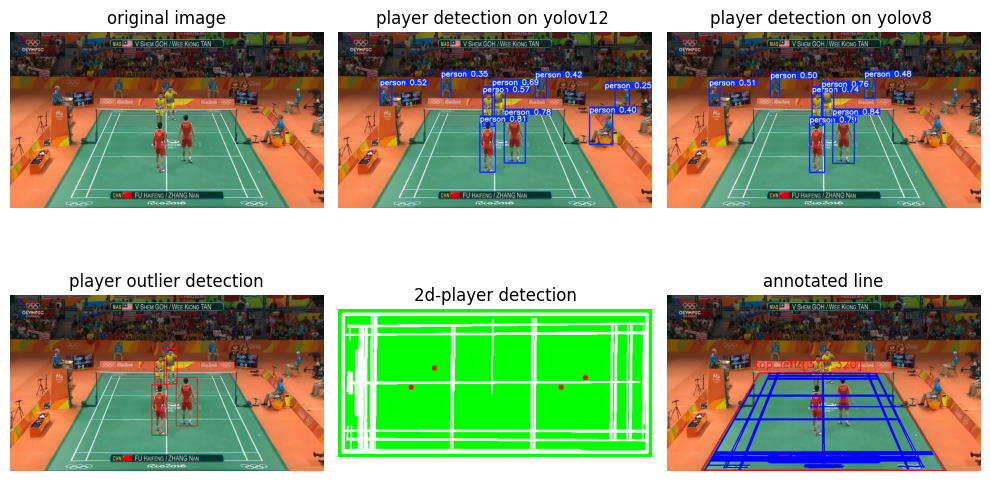

In [21]:
sample_img = cv2.imread(sample_imgs[1])
sample_img_y12 = sample_img.copy()
sample_img_y12_rgb = cv2.cvtColor(sample_img_y12,cv2.COLOR_BGR2RGB)

annotated_img_y12 = results_target_y12[0].plot() #BGR
annotated_img_y12_rgb = annotated_img_y12[..., ::-1]

annotated_img_y8 = results_target_y8[0].plot() #BGR
annotated_img_y8_rgb = annotated_img_y8[..., ::-1]
#sample_img_y12_rgb = cv2.cvtColor(sample_img_y12,cv2.COLOR_BGR2RGB)

sample_img_floor_play, court_edges_extractor_player, top_view_image_player, scale_map = draw_outline(sample_img, False, True)
target_player_result, person_position_results = get_target_player(sample_img_y12)

draw_player_position(top_view_image_player, person_position_results, scale_map)


fig, axes = plt.subplots(2, 3, figsize = (10, 6))

axes[0, 0].axis('off')
axes[0, 0].imshow(sample_img_y12_rgb)
axes[0, 0].set_title("original image")

axes[0, 1].axis('off')
axes[0, 1].imshow(annotated_img_y12_rgb)
axes[0, 1].set_title(f"player detection on yolov12 ")

axes[0, 2].axis('off')
axes[0, 2].imshow(annotated_img_y8_rgb)
axes[0, 2].set_title("player detection on yolov8 ")

axes[1, 0].axis('off')
axes[1, 0].imshow(target_player_result)
axes[1, 0].set_title("player outlier detection")

axes[1, 1].axis('off')
axes[1, 1].imshow(top_view_image_player)
axes[1, 1].set_title("2d-player detection")

axes[1, 2].axis('off')
axes[1, 2].imshow(sample_img_floor_play)
axes[1, 2].set_title("annotated line")

plt.tight_layout()
plt.show()

### Result

As the figure is shown, the detection of the person on the YOLO12(image2) is more accurate than the YOLO8(image3) as more people are identified. The players are highlighted by the red box (image4). The position of the players are located on the 2d top view(image5).
It is clear that the position of the player has been rotated. For the calculation of the percentage of the overlay area, the issue is the total area. It is unknown that the players could be detected if some of their parts are outside the image. YOLO offers the prediection of the pose, which means the total area of the people can be calculated from head to feet rather than the part which is in the image.

## 1.3 Task3: the simulation of the motion

### Method

There are many approaches which can be used to track the motion of object such as optial flow, mean-shift. The optial flow is useful to measure the motion of the pixel, and the mean-shift is helpful for non-rigid object tracking based on color. 

This experiment tested the deep sort module as it contributes to multiple object track for a long period through traker id. This model is required to bind a detector like yolo. For the estimation of the motion, a KalmanFilter is employed to predict the possible location in the next frame.

### Code

In [23]:
samples = [single_imgs[i] for i in range(20, 24)]

In [25]:
deep_tracker = DeepSort(max_age = 60, n_init = 3, nms_max_overlap = 1.0)
tracker_dic = {}

for sample in samples:
    img_origin = cv2.imread(sample)
    results_target_y12 = model_y12.predict(img_origin, classes = [0])
    
    conners = get_conner(img_origin)    
    # flatten the array
    points_conner = conners#.reshape(-1, 2)
    conner_ploy = Polygon(points_conner)
    
    player_detectors = []
    for box_person in results_target_y12[0].boxes:
        if box_person.cls == 0:
            x1, y1, x2, y2 = box_person.xyxy[0]
            if is_player(x1, y1, x2, y2, conner_ploy):
                w, h = x2 - x1, y2 - y1
                accuracy = float(box_person.conf[0])
                player_detectors.append([[x1, y1, w, h], accuracy, "player"])
    deep_trackers = deep_tracker.update_tracks(player_detectors, frame = img_origin)    

    #img_result = img_origin.copy()
    #img_rgb = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_rgb)
    
    #axis = plt.gca()
    for tracker in deep_trackers:
        if not tracker.is_confirmed():
            continue
        x1, y1, x2, y2 = tracker.to_ltrb()
        tracker_id = tracker.track_id
        tracker_box = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                            lw = 2, edgecolor = 'red', facecolor = 'none')
        rect = (x1, y1, x2, y2)
        #axis.add_patch(tracker_box)
        #axis.text(x1, y1 - 5, f"player {tracker_id}", color = 'red')
        if tracker_id in tracker_dic:
            tracker_dic[tracker_id].append(rect)
        else:
            tracker_dic[tracker_id] = [rect]

    #plt.axis("off")
    #plt.title("deepsort player tracker")

#plt.show()



/opt/anaconda3/envs/sport_target/lib/python3.11/site-packages/deep_sort_realtime/embedder/embedder_pytorch.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources



0: 384x640 9 persons, 2973.7ms
Speed: 42.2ms preprocess, 2973.7ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3770.4ms
Speed: 5.3ms preprocess, 3770.4ms inference, 26.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 3714.5ms
Speed: 45.1ms preprocess, 3714.5ms inference, 10.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 4467.2ms
Speed: 46.5ms preprocess, 4467.2ms inference, 30.5ms postprocess per image at shape (1, 3, 384, 640)



0: 384x640 9 persons, 4312.3ms
Speed: 33.2ms preprocess, 4312.3ms inference, 60.6ms postprocess per image at shape (1, 3, 384, 640)


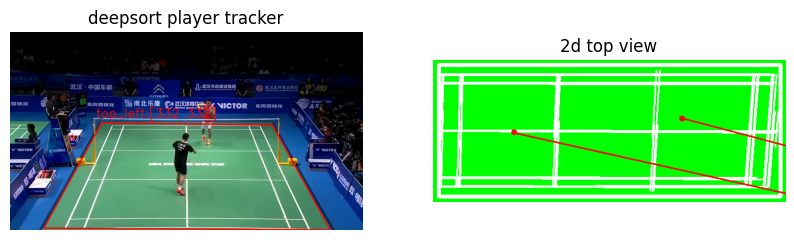

In [27]:
def draw_player_line(top_view, positions, scale_3d_2d):
    points_2d = get_2d_point(positions, scale_3d_2d)
    for index in range(len(points_2d)-1):
        pos_i = tuple(points_2d[index].astype(int))
        pos_i_1 = tuple(points_2d[index+1].astype(int))
        cv2.line(top_view, pos_i, pos_i_1, box_color, 2)
        
test_img = cv2.imread(samples[0]).copy()
sample_img_floor_play, court_edges_extractor_player, top_view_image_player, scale_map = draw_outline(test_img, True, False)
target_player_result, person_position_results = get_target_player(test_img)

draw_player_position(top_view_image_player, person_position_results, scale_map)

for t_id, t_rects in tracker_dic.items():
    positions = np.zeros((len(t_rects), 2))
    index = 0
    for t_rect in t_rects:
        x1,y1,x2,y2 = t_rect
        positions[index][0] = (x1 + x2) / 2
        positions[index][1] = y2
    draw_player_line(top_view_image_player, positions, scale_map)

img_test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize = (10, 6))
axes[0].axis('off')
axes[0].imshow(sample_img_floor_play)
axes[0].set_title("deepsort player tracker")

axes[1].axis('off')
axes[1].imshow(top_view_image_player)
axes[1].set_title(f"2d top view")


plt.show()

### Result

The position of the players seems not convert correctly.